In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

from utils import votable_to_pandas
from astropy.table import Table

In [3]:
df_csc_all = votable_to_pandas('data/allcsc_new.vot') # All CSC

t_nway = Table.read('data/nway_CSC21p_GAIA21p.fits', format='fits')

# Loop through all columns to find byte-string columns and convert them to strings
for col in t_nway.columns:
    if t_nway[col].dtype.kind == 'S':
        t_nway[col] = t_nway[col].astype(str)
        
# If you want to convert it into a Pandas DataFrame
df_nway_all = t_nway.to_pandas()


In [4]:
df_nway_all[['CSC21P_CSCID', 'GAIA21P_source_id', 'p_any', 'p_i', 'Separation_GAIA21P_CSC21P']]

,CSC21P_CSCID,GAIA21P_source_id,p_any,p_i,Separation_GAIA21P_CSC21P
0,2CXO_J201627.1-071025,4216298682145136000,0.987355,2.231779e-28,8.638845
1,2CXO_J201627.1-071025,4216298686436921088,0.987355,1.235377e-18,8.682389
2,2CXO_J201627.1-071025,4216298686440345088,0.987355,1.000000e+00,0.482556
3,2CXO_J201633.9-071145,4216298411563165440,0.992170,1.000000e+00,0.055372
4,2CXO_J201633.9-071145,4216298445918725376,0.992170,2.278740e-08,4.212566
...,...,...,...,...,...
1079661,2CXO_J175954.8-273333,4062801400047293184,0.552185,8.938274e-02,4.143907
1079662,2CXO_J175954.8-273333,4062801400103152640,0.552185,6.757107e-02,5.399296
1079663,2CXO_J175954.8-273333,4062801400103153408,0.552185,3.047921e-02,7.952766
1079664,2CXO_J175954.8-273333,4062801400103153664,0.552185,1.354719e-02,9.898051


In [5]:
df_csc_off_axis = votable_to_pandas('data/csc_min_theta_mean.vot')

In [6]:
selected_cols_off = [col for col in df_csc_all.columns if col not in ['ra', 'dec']]
df_csc_all_with_off = df_csc_all.merge(df_csc_off_axis[['name', 'min_theta_mean']], left_on='name', right_on='name', how='left')

In [7]:
csc_multiple_gaia = df_nway_all.groupby('CSC21P_CSCID').filter(lambda x: len(x) > 1)['CSC21P_CSCID'].unique()
df_filtered = df_nway_all[df_nway_all['CSC21P_CSCID'].isin(csc_multiple_gaia)]

In [8]:
df_most_probable = df_filtered.loc[df_filtered.groupby('CSC21P_CSCID')['p_i'].idxmax()]

In [9]:
df_most_probable[df_most_probable.CSC21P_CSCID == '2CXO_J201627.1-071025 ']

,ENS,CSC21P_CSCID,CSC21P_ensemble,CSC21P_ra,CSC21P_dec,CSC21P_Errmaj,CSC21P_Errmin,CSC21P_ErrPA,CSC21P_flag,GAIA21P_source_id,...,dist_bayesfactor,dist_post,p_single,p_any,p_i,match_flag,EPOS1,EPOS2,EPOS,SEP_EPOS
2,ens0605500,2CXO_J201627.1-071025,ens0605500_001,304.113211,-7.173878,0.934972,0.745255,125.34459,true,4216298686440345088,...,11.01573,0.987355,0.987355,0.987355,1.0,1,0.834741,0.000016,0.834741,0.578091


<Axes: >

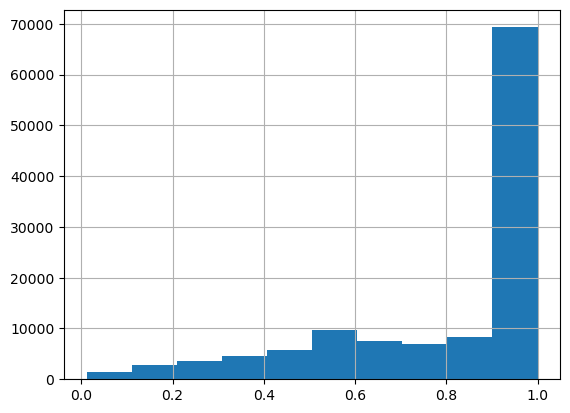

In [10]:
df_most_probable.p_i.hist()

In [11]:
# First, sort the DataFrame based on 'CSC21P_CSCID' and 'p_i'
df_sorted_nway = df_filtered.sort_values(['CSC21P_CSCID', 'p_i'], ascending=[True, False])

# Group by 'CSC21P_CSCID' and pick the second highest 'p_i'
df_second_most_probable = df_sorted_nway.groupby('CSC21P_CSCID').nth(1).reset_index()

In [12]:
df_second_most_probable[df_second_most_probable.CSC21P_CSCID == '2CXO_J201627.1-071025 ']

,CSC21P_CSCID,ENS,CSC21P_ensemble,CSC21P_ra,CSC21P_dec,CSC21P_Errmaj,CSC21P_Errmin,CSC21P_ErrPA,CSC21P_flag,GAIA21P_source_id,...,dist_bayesfactor,dist_post,p_single,p_any,p_i,match_flag,EPOS1,EPOS2,EPOS,SEP_EPOS
110220,2CXO_J201627.1-071025,ens0605500,ens0605500_001,304.113211,-7.173878,0.934972,0.745255,125.34459,true,4216298686436921088,...,-6.892469,9.646349e-17,9.646349e-17,0.987355,1.235377e-18,0,0.834741,0.000296,0.834741,10.401298


<Axes: >

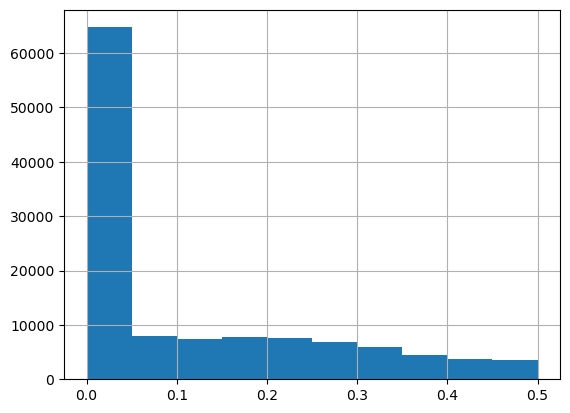

In [13]:
df_second_most_probable.p_i.hist()

In [14]:
# Group by 'CSC21P_CSCID' and pick the last 'p_i'
df_last_probable = df_sorted_nway.groupby('CSC21P_CSCID').nth(-1).reset_index()

<Axes: >

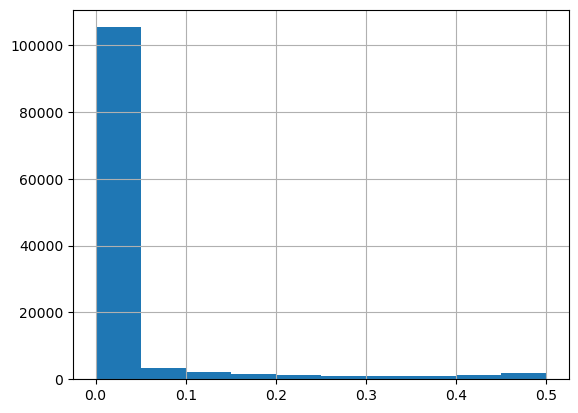

In [15]:
df_last_probable.p_i.hist()

In [16]:
df_most_probable.to_csv('out_data/most_probable_new.csv')
df_second_most_probable.to_csv('out_data/second_new.csv')
df_last_probable.to_csv('out_data/last_new.csv')

In [20]:
import gzip
# Reading the compressed VOTable file
with gzip.open('data/most_probable.gz', 'rb') as f:
    votable = Table.read(f, format='votable')

# Converting to Pandas DataFrame
most_probable = votable.to_pandas()

In [21]:
# Reading the compressed VOTable file
with gzip.open('data/second_prob.gz', 'rb') as f:
    votable = Table.read(f, format='votable')

# Converting to Pandas DataFrame
second_prob = votable.to_pandas()

In [22]:
# Reading the compressed VOTable file
with gzip.open('data/last_prob.gz', 'rb') as f:
    votable = Table.read(f, format='votable')

# Converting to Pandas DataFrame
last_prob = votable.to_pandas()

In [23]:
def prepare_dataset(df):
    df['chandra_source_id'] = df['chandra_source_id'].str.replace('_', ' ')
    # Exclude the 'name', 'ra', and 'dec' columns from df_csc_all
    selected_columns = [col for col in df_csc_all_with_off.columns if col not in ['ra', 'dec']]
    all_columns = list(df.columns)

    # Merge the DataFrames
    merged_df = df.merge(df_csc_all_with_off[selected_columns], left_on='chandra_source_id', right_on='name', how='left')
    # Split the columns into two parts: before and after 'chandra_dec'
    before_chandra_dec = all_columns[:all_columns.index('chandra_dec') + 1]
    after_chandra_dec = all_columns[all_columns.index('chandra_dec') + 1:]

    # Reorder the columns
    new_column_order = before_chandra_dec + selected_columns + after_chandra_dec
    merged_df = merged_df[new_column_order]

    return merged_df

In [39]:
merged_df = prepare_dataset(last_prob)

In [40]:
merged_df.to_csv('out_data/last_new.csv')

In [87]:
def_last_prob_df = pd.read_csv('out_data/def_last_prob.csv')
def_second_prob_df = pd.read_csv('out_data/def_second_prob.csv')
def_first_prob_df = pd.read_csv('out_data/def_most_prob.csv')

In [93]:
def_last_prob_df.min_theta_mean

0         1.071654
1         7.187437
2         7.401238
3         9.190437
4         6.764671
            ...   
119870         NaN
119871    6.914585
119872         NaN
119873    0.878216
119874    5.987952
Name: min_theta_mean, Length: 119875, dtype: float64

In [193]:
#def_first_prob_df = def_first_prob_df.query('nway_separation > 3')
# Extract unique chandra_source_id values from def_first_prob_df
chandra_ids_in_first = def_first_prob_df['chandra_source_id'].unique()

# Filter def_second_prob_df and def_last_prob_df based on the extracted chandra_source_id values
filtered_second_prob_df = def_second_prob_df[def_second_prob_df['chandra_source_id'].isin(chandra_ids_in_first)]
filtered_last_prob_df = def_last_prob_df[def_last_prob_df['chandra_source_id'].isin(chandra_ids_in_first)]

In [194]:
from matplotlib.backends.backend_pdf import PdfPages

features = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_over_error',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
]

with PdfPages('figures/chandra_gaia_nway_exp/distributions_separation_all_s.pdf') as pdf:
    for feature in features:
        fig, ax = plt.subplots(figsize=(15, 5))
        
        if feature == 'parallax':
            ax.hist(np.log10(1/def_first_prob_df[feature]), bins=40, histtype='step', linewidth=3, label='First', density=True)
            ax.hist(np.log10(1/filtered_second_prob_df[feature]), bins=40, histtype='step', linewidth=3, label='Second', density=True)
            ax.hist(np.log10(1/filtered_last_prob_df[feature]), bins=40, histtype='step', linewidth=3, label='Last', density=True)
            ax.set_title(f'log(1/{feature})')
            
        elif feature == 'parallax_over_error' or feature == 'flux_aper_b':
            ax.hist(np.log10(def_first_prob_df[feature]), bins=40, histtype='step', linewidth=3, label='First', density=True)
            ax.hist(np.log10(filtered_second_prob_df[feature]), bins=40, histtype='step', linewidth=3, label='Second', density=True)
            ax.hist(np.log10(filtered_last_prob_df[feature]), bins=40, histtype='step', linewidth=3, label='Last', density=True)
            ax.set_title(f'log({feature})')
            
        else:
            ax.hist(def_first_prob_df[feature], bins=40, histtype='step', linewidth=3, label='First', density=True)
            ax.hist(filtered_second_prob_df[feature], bins=40, histtype='step', linewidth=3, label='Second', density=True)
            ax.hist(filtered_last_prob_df[feature], bins=40, histtype='step', linewidth=3,label='Last', density=True)
            ax.set_title(f'{feature}')
        
        ax.legend()

        pdf.savefig(fig)  # Saves the current figure into a PDF page
        plt.close()  # Close the figure to free up memory

/home/ubunsam/miniconda3/envs/starsml/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
df_mp_dongwoo = df_most_probable.query('Separation_GAIA21P_CSC21P < 3 and match_flag == 1 and p_any > 0.5')

In [42]:
# Step 1: Find CSC sources with multiple GAIA sources (with p_any > 0.1)
df_most_p_any = df_nway_all.query('p_any > 0.1')
csc_multiple_gaia = [] #df_most_p_any.groupby('CSC21P_CSCID').filter(lambda x: len(x) > 1)['CSC21P_CSCID'].unique()

df_most_gaia = df_nway_all.query('match_flag == 1')
# Step 2: Find GAIA sources with multiple CSC sources
gaia_multiple_csc = df_most_p_any.groupby('GAIA21P_source_id').filter(lambda x: len(x) > 1)['GAIA21P_source_id'].unique()

# Step 3: Filter out ambiguous sources
df_filtered = df_nway_all[~df_nway_all['CSC21P_CSCID'].isin(csc_multiple_gaia)]
df_filtered = df_filtered[~df_filtered['GAIA21P_source_id'].isin(gaia_multiple_csc)]

In [26]:
count_ensembles = df_nway_all['CSC21P_CSCID'].value_counts()
single_ensemble_sources = count_ensembles[count_ensembles == 1].index
df_single_ensemble = df_nway_all[df_nway_all['CSC21P_CSCID'].isin(single_ensemble_sources)]


In [28]:
df_single_ensemble.shape

(87362, 36)

In [3]:
df_csc_optical_pos_pre = votable_to_pandas('data/chandra_optical_positives-result.vot')
df_csc_optical_pos = df_csc_optical_pos_pre.merge(df_csc_all, left_on='chandra_source_id', right_on='name', how='left')

df_csc_optical_neg_pre = votable_to_pandas('data/chandra_optical_negatives-result.vot')
df_csc_optical_neg_pre = df_csc_optical_neg_pre.loc[df_csc_optical_neg_pre.groupby('chandra_source_id')['dist_arcsec'].idxmax()]
df_csc_optical_neg = df_csc_optical_neg_pre.merge(df_csc_all, left_on='chandra_source_id', right_on='name', how='left')

In [4]:
df_pos = df_csc_optical_pos.query('nway_sep <= 0.2 and parallax == parallax and parallax >= 0')
# Find the intersection of 'csc2_id' in both df_good and df_bad
intersecting_ids = set(df_pos['chandra_source_id']).intersection(set(df_csc_optical_neg['chandra_source_id']))

# Filter the dataframes to only include these intersecting IDs
df_pos_intersect = df_pos[df_pos['chandra_source_id'].isin(intersecting_ids)]
df_neg_intersect = df_csc_optical_neg[df_csc_optical_neg['chandra_source_id'].isin(intersecting_ids)]

# This will filter df_bad_intersect to only include rows where the source_id is NOT in df_good_intersect
df_neg = df_neg_intersect[~df_neg_intersect.source_id.isin(df_pos_intersect.source_id)]

df_pos = df_pos_intersect
df_pos['flux_aper_b'].replace(0, np.nan, inplace=True)
df_neg['flux_aper_b'].replace(0, np.nan, inplace=True)
df_pos['gmag_logflux'] = df_pos['phot_g_mean_mag'] + np.log10(df_pos['flux_aper_b']/1e-13)*2.5
df_neg['gmag_logflux'] = df_neg['phot_g_mean_mag'] + np.log10(df_neg['flux_aper_b']/1e-13)*2.5

/tmp/ipykernel_14402/2871272599.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['flux_aper_b'].replace(0, np.nan, inplace=True)
/tmp/ipykernel_14402/2871272599.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['gmag_logflux'] = df_neg['phot_g_mean_mag'] + np.log10(df_neg['flux_aper_b']/1e-13)*2.5


/tmp/ipykernel_14402/858040766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['distance'] = 1000 / df_neg['parallax']
/home/ubunsam/miniconda3/envs/starsml/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_14402/858040766.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['log_inv_plx'] = np.log10(1 / df_neg['parallax'])


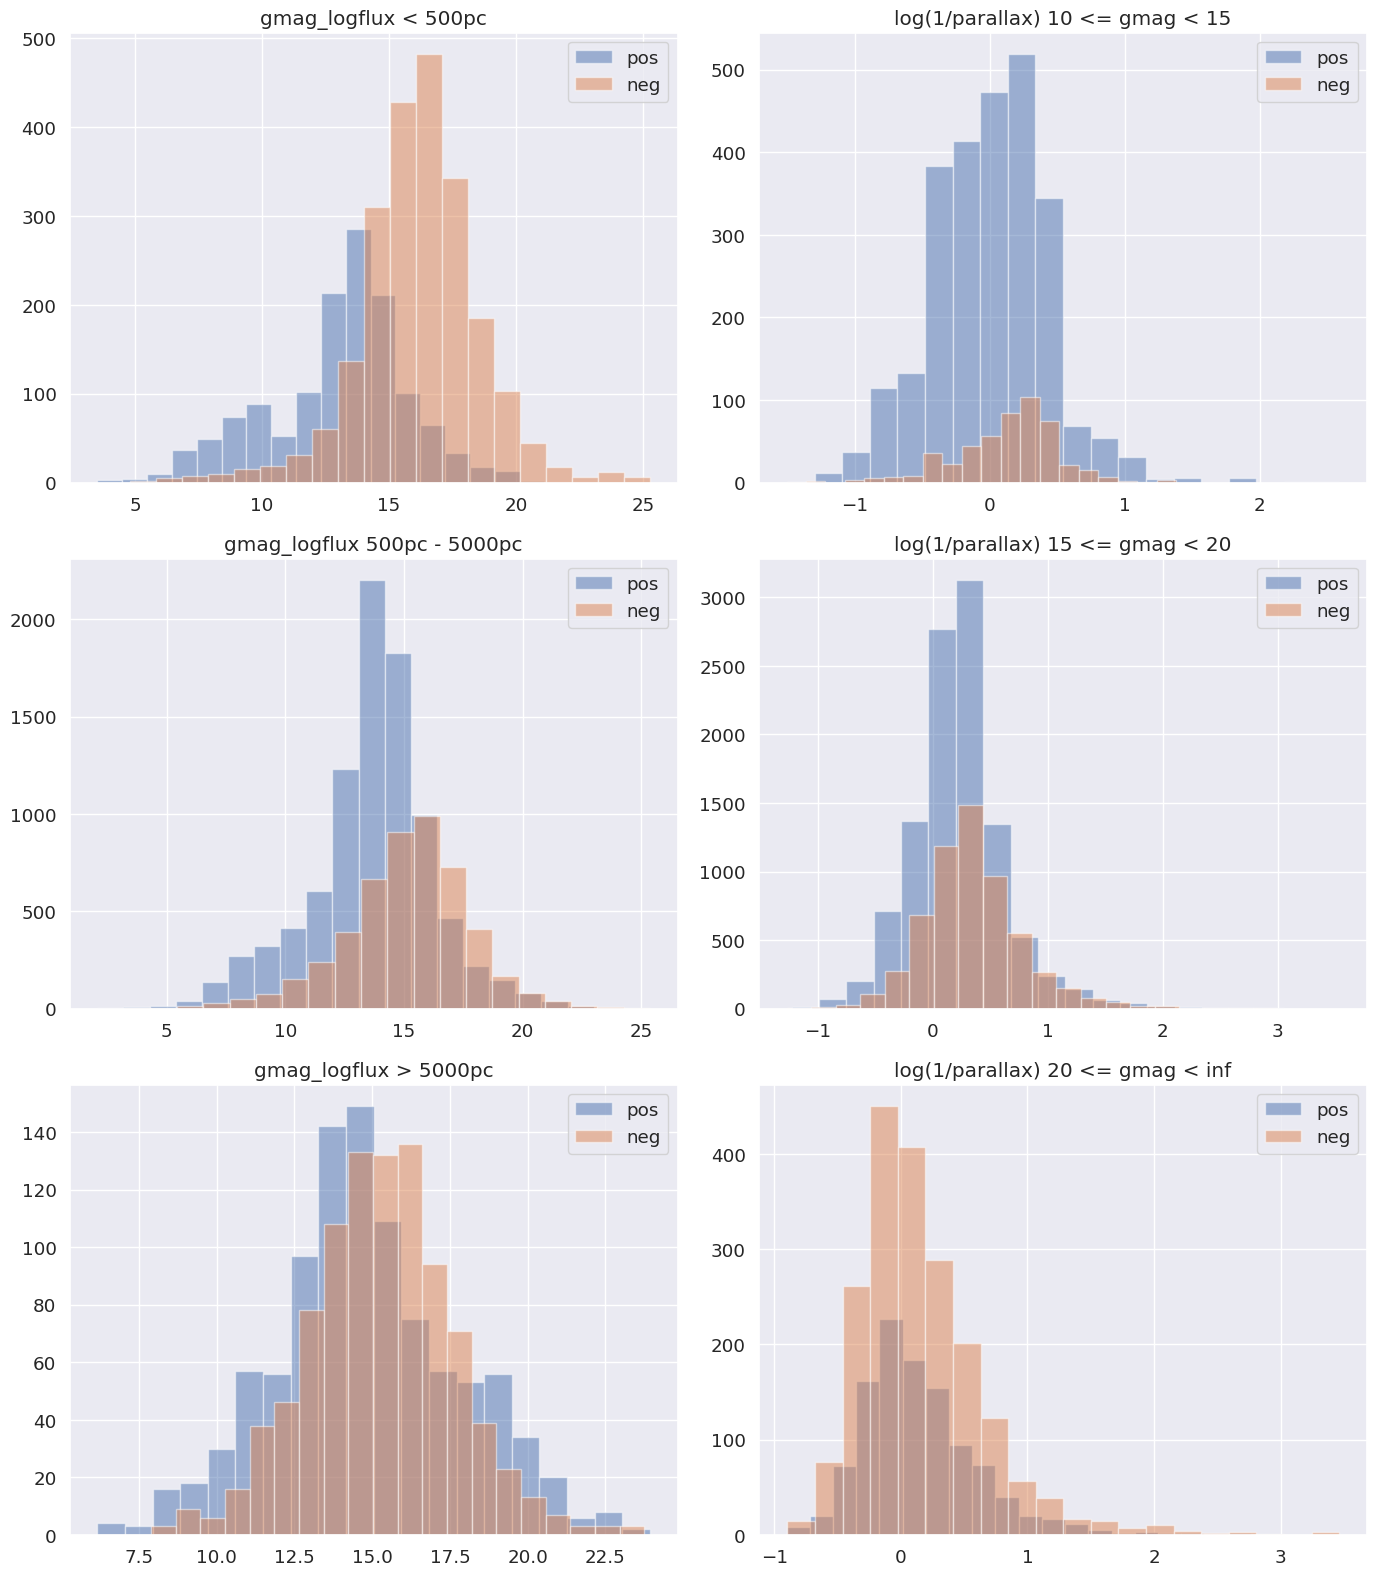

In [27]:
# distances
df_pos['distance'] = 1000 / df_pos['parallax']
df_neg['distance'] = 1000 / df_neg['parallax']

# Calculate log(1/plx)
df_pos['log_inv_plx'] = np.log10(1 / df_pos['parallax'])
df_neg['log_inv_plx'] = np.log10(1 / df_neg['parallax'])

# Plot settings
bins = 20

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 16))

# Plot for gmag_logflux < 500pc
axs[0, 0].hist(df_pos[df_pos['distance'] < 500]['gmag_logflux'], bins=bins, alpha=0.5, label='pos')
axs[0, 0].hist(df_neg[df_neg['distance'] < 500]['gmag_logflux'], bins=bins, alpha=0.5, label='neg')
axs[0, 0].set_title('gmag_logflux < 500pc')
axs[0, 0].legend()

# Plot for 500pc <= gmag_logflux <= 5000pc
axs[1, 0].hist(df_pos[(df_pos['distance'] >= 500) & (df_pos['distance'] <= 5000)]['gmag_logflux'], bins=bins, alpha=0.5, label='pos')
axs[1, 0].hist(df_neg[(df_neg['distance'] >= 500) & (df_neg['distance'] <= 5000)]['gmag_logflux'], bins=bins, alpha=0.5, label='neg')
axs[1, 0].set_title('gmag_logflux 500pc - 5000pc')
axs[1, 0].legend()

# Plot for gmag_logflux > 5000pc
axs[2, 0].hist(df_pos[df_pos['distance'] > 5000]['gmag_logflux'], bins=bins, alpha=0.5, label='pos')
axs[2, 0].hist(df_neg[df_neg['distance'] > 5000]['gmag_logflux'], bins=bins, alpha=0.5, label='neg')
axs[2, 0].set_title('gmag_logflux > 5000pc')
axs[2, 0].legend()

# Plot for undefined/negative distances (log_inv_plx for gmag of 10-15, 15-20, >20)
for i, (gmag_lower, gmag_upper) in enumerate([(10, 15), (15, 20), (20, float('inf'))]):
    axs[i, 1].hist(df_pos[(df_pos['phot_g_mean_mag'] >= gmag_lower) & (df_pos['phot_g_mean_mag'] < gmag_upper)]['log_inv_plx'], bins=bins, alpha=0.5, label='pos')
    axs[i, 1].hist(df_neg[(df_neg['phot_g_mean_mag'] >= gmag_lower) & (df_neg['phot_g_mean_mag'] < gmag_upper)]['log_inv_plx'], bins=bins, alpha=0.5, label='neg')
    axs[i, 1].set_title(f'log(1/parallax) {gmag_lower} <= gmag < {gmag_upper}')
    axs[i, 1].legend()

plt.tight_layout()
plt.savefig('figures/chandra_optical_dw/distributions_strat_vinay.pdf')


In [5]:
df_pos.shape

(14643, 61)

In [6]:
df_all = pd.concat([df_pos, df_neg], ignore_index=True)

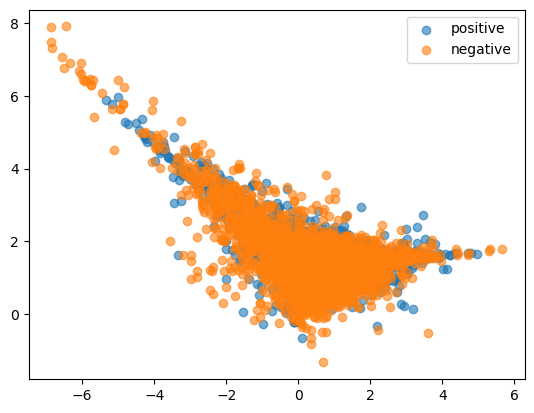

In [7]:
plt.scatter(df_pos['bp_g'],df_pos['g_rp'],alpha=0.6, label='positive')
plt.scatter(df_neg['bp_g'],df_neg['g_rp'],alpha=0.6, label='negative')
plt.legend()

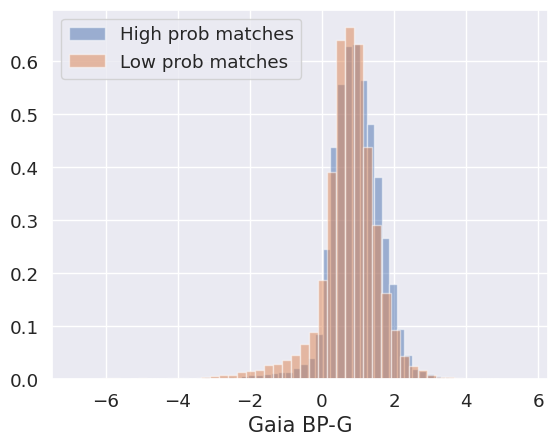

In [161]:
plt.hist(df_pos['bp_g'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_neg['bp_g'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-G',size=15)
plt.legend()
#plt.savefig('figures/Gaia_BP_G.pdf',dpi=300)

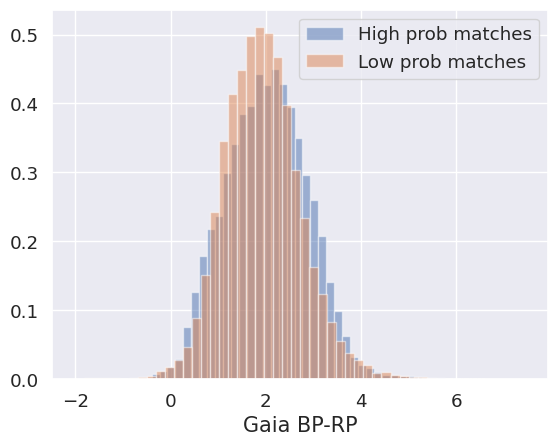

In [133]:
plt.hist(df_pos['bp_rp'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_neg['bp_rp'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-RP',size=15)
plt.legend()
#plt.savefig('figures/Gaia_BP_RP.pdf',dpi=300)

/home/ubunsam/miniconda3/envs/starsml/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


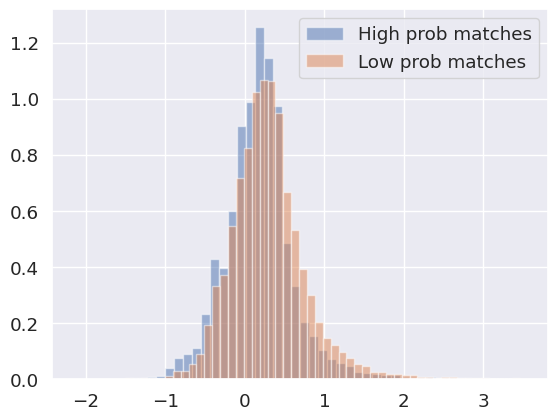

In [166]:
plt.hist(np.log10(1/df_pos['parallax']),bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(np.log10(1/df_neg['parallax']),bins=50,alpha=0.5,density=True,label='Low prob matches')
#plt.xlabel('Gaia G-RP',size=15)
plt.legend()
#plt.savefig('figures/Gaia_G_RP.pdf',dpi=300)

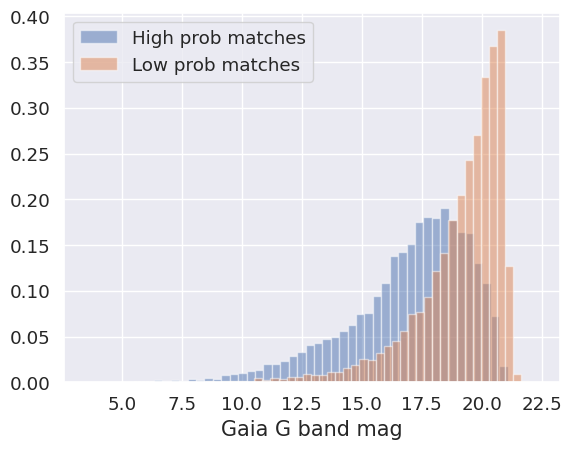

In [135]:
plt.hist(df_pos['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_neg['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia G band mag',size=15)
#plt.xscale('log')
plt.legend()
#plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

---
#### Preprocessing

In [8]:
feature_names = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_over_error',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
    'flux_aper_b',
    'gmag_logflux'
]

# List of features to skip for the log transformation
skip_log_features = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
    'gmag_logflux'
]

from utils import preprocess, transform_features, handle_missing_values, standardize

In [9]:
# Preprocess the data
X, Y = preprocess(df_pos, df_neg, feature_names, skip_log_features)
indices = np.arange(X.shape[0])

# Split into training and test sets
(X_train, 
 X_test, 
 Y_train, 
 Y_test, 
 indices_train, 
 indices_test) = train_test_split(X, Y, indices, test_size=0.3, shuffle=True)

# Handle missing values
X_train, X_test, imp_mean = handle_missing_values(X_train, X_test)

# Standardize
#X_train, X_test, scaler = standardize(X_train, X_test)

/mnt/d/workspace/starsml/utils.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(1 + df[feature].values) if feature not in skip_log_features else df[feature].values


In [10]:
from collections import Counter

def class_proportions(y):
    counts = Counter(y)
    total = len(y)
    proportions = {key: value / total for key, value in counts.items()}
    return proportions

train_proportions = class_proportions(Y_train)
test_proportions = class_proportions(Y_test)

print("Training proportions:", train_proportions)
print("Test proportions:", test_proportions)

Training proportions: {1.0: 0.5170129935790485, 0.0: 0.4829870064209515}
Test proportions: {0.0: 0.47900448218919556, 1.0: 0.5209955178108044}


In [11]:
num_samples = X.shape[0]
nan_count_per_feature = np.isnan(X).sum(axis=0)

# Calculate the percentage for each feature
nan_percentage_per_feature = (nan_count_per_feature / num_samples) * 100

for i, percentage in enumerate(nan_percentage_per_feature):
    print(f"Percentage of NaN values in feature {feature_names[i]}: {percentage:.2f}%")


Percentage of NaN values in feature phot_g_mean_mag: 0.47%
Percentage of NaN values in feature phot_bp_mean_mag: 8.91%
Percentage of NaN values in feature phot_rp_mean_mag: 7.73%
Percentage of NaN values in feature bp_rp: 8.97%
Percentage of NaN values in feature bp_g: 8.91%
Percentage of NaN values in feature g_rp: 8.13%
Percentage of NaN values in feature parallax: 11.74%
Percentage of NaN values in feature parallax_over_error: 12.85%
Percentage of NaN values in feature hard_hs: 21.52%
Percentage of NaN values in feature hard_hm: 21.27%
Percentage of NaN values in feature hard_ms: 21.84%
Percentage of NaN values in feature var_intra_prob_b: 18.49%
Percentage of NaN values in feature var_inter_prob_b: 47.42%
Percentage of NaN values in feature flux_aper_b: 22.41%
Percentage of NaN values in feature gmag_logflux: 22.78%


---
#### Baseline Models

In [12]:
# Model Building
clf_rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=4)
clf_rf.fit(X_train, Y_train)

# Predictions
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_prob = clf_rf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print(f"RF train accuracy: {clf_rf.score(X_train, Y_train):.3f}")
print("Accuracy:", accuracy_score(Y_test, y_pred_rf))
print("Precision:", precision_score(Y_test, y_pred_rf))
print("Recall:", recall_score(Y_test, y_pred_rf))
print("F1 Score:", f1_score(Y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_rf_prob))

# Check Scalar and Missing Values
# Error Analysis (check distances of matches in errors)

RF train accuracy: 0.943
Accuracy: 0.8024298183533852
Precision: 0.7796817625458996
Recall: 0.8652931854199684
F1 Score: 0.8202596845155059
AUC-ROC: 0.8774334371181346


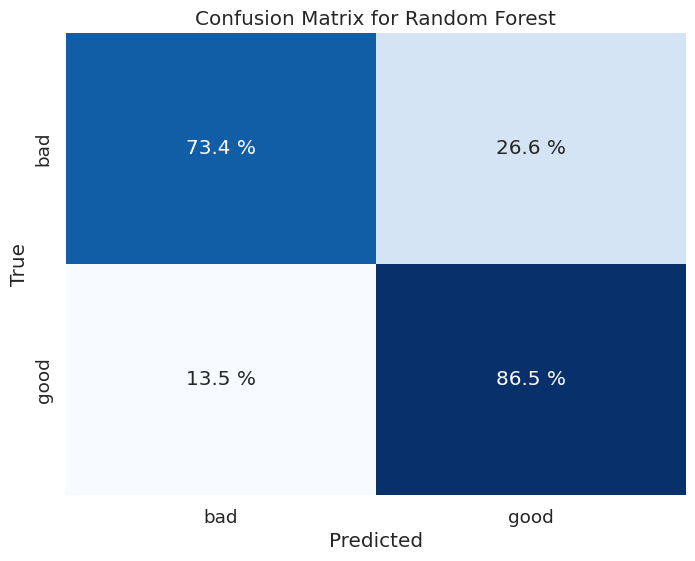

In [15]:
# Compute the confusion matrix and normalize it to get percentages
cm = confusion_matrix(Y_test, y_pred_rf, normalize='true')

# Multiply by 100 to get percentages and round to 1 decimal place
cm_percentage = (cm * 100).round(1)

# Define the class labels
class_labels = ['bad', 'good']

# Create a Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) # Adjust to your preference
sns.heatmap(cm_percentage, annot=True, fmt='', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={'va':'center'},
            )

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest')

# Iterate through the heatmap to add the '%' sign to the annotations
for t in plt.gca().texts:
    t.set_text(t.get_text() + " %")

plt.savefig('figures/chandra_optical_dw/confusion_rf_.png', dpi=300)

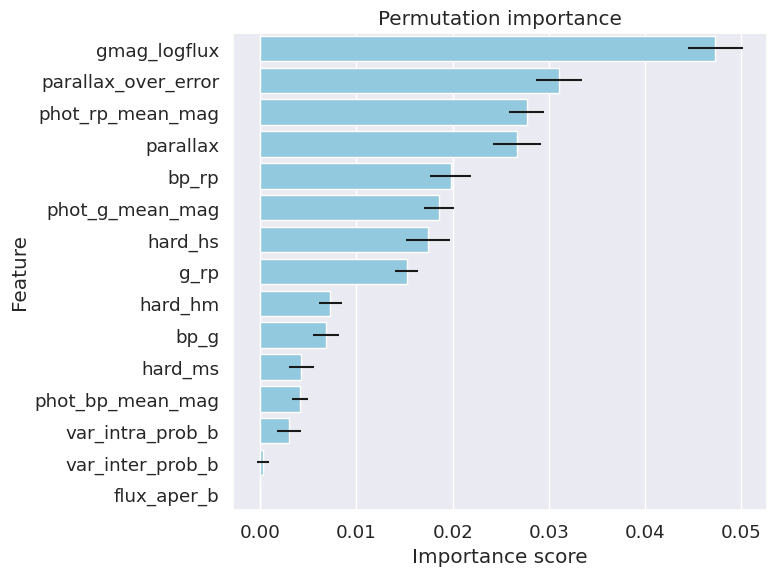

In [23]:
# Calculate permutation importances
per_importances = permutation_importance(
    clf_rf, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
)

# Sort the features by importance in descending order
sorted_idx = per_importances.importances_mean.argsort()[::-1]

# Create a Pandas DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': np.array(feature_names)[sorted_idx],
    'Importance': per_importances.importances_mean[sorted_idx],
    'Importance_std': per_importances.importances_std[sorted_idx]
})

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue', errorbar=None, capsize=.1, xerr=importance_df['Importance_std'])

# Add labels and title
plt.title("Permutation importance")
plt.xlabel("Importance score")
plt.tight_layout()
plt.savefig('figures/chandra_optical_dw/feature_importances_RF_10232023.pdf')

In [16]:
# Sample dataframes (replace these with your real df_train, df_test, df_totest)
df_train = df_all.iloc[indices_train]
df_train['prediction'] = clf_rf.predict(X_train)
df_train['actual'] = Y_train
y_train_rf_prob = clf_rf.predict_proba(X_train)[:, 1]

df_test = df_all.iloc[indices_test]
df_test['prediction'] = y_pred_rf
df_test['actual'] = Y_test

# List of dataframes and their names
dfs = [df_train, df_test]
names = ['Train', 'Test']

features = feature_names

/tmp/ipykernel_14402/3311305092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['prediction'] = clf_rf.predict(X_train)
/tmp/ipykernel_14402/3311305092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['actual'] = Y_train
/tmp/ipykernel_14402/3311305092.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [19]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('figures/chandra_optical_dw/distributions_predicted_datasets_cop.pdf') as pdf:
    for feature in features:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 3 columns for Train, Test, ToTest
    
        for ax, df, name in zip(axs, dfs, names):
            if feature == 'parallax':
                ax.hist(np.log10(1/df[df['prediction'] == 1][feature]), bins=20, alpha=0.5, label='+ve')
                ax.hist(np.log10(1/df[df['prediction'] == 0][feature]), bins=20, alpha=0.5, label='-ve')
                ax.set_title(f'{name} - log(1/{feature})')

            elif feature == 'parallax_over_error' or feature == 'flux_aper_b':
                ax.hist(np.log10(df[df['prediction'] == 1][feature]), bins=20, alpha=0.5, label='+ve')
                ax.hist(np.log10(df[df['prediction'] == 0][feature]), bins=20, alpha=0.5, label='-ve')
                ax.set_title(f'{name} - log({feature})')
            else:
                ax.hist(df[df['prediction'] == 1][feature], bins=20, alpha=0.5, label='+ve')
                ax.hist(df[df['prediction'] == 0][feature], bins=20, alpha=0.5, label='-ve')
                ax.set_title(f'{name} - {feature}')
            ax.legend()

        pdf.savefig(fig);  # Saves the current figure into a pdf page
        plt.close();  # Close the figure to free up memory

/home/ubunsam/miniconda3/envs/starsml/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/tmp/ipykernel_14402/3307290578.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['l_rad'] = l_rad
/tmp/ipykernel_14402/3307290578.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['b_rad'] = b_rad
/home/ubunsam/miniconda3/envs/starsml/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'rasterized'
  cset = contour_func(
/home/ubunsam/miniconda3/envs/starsml/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarnin

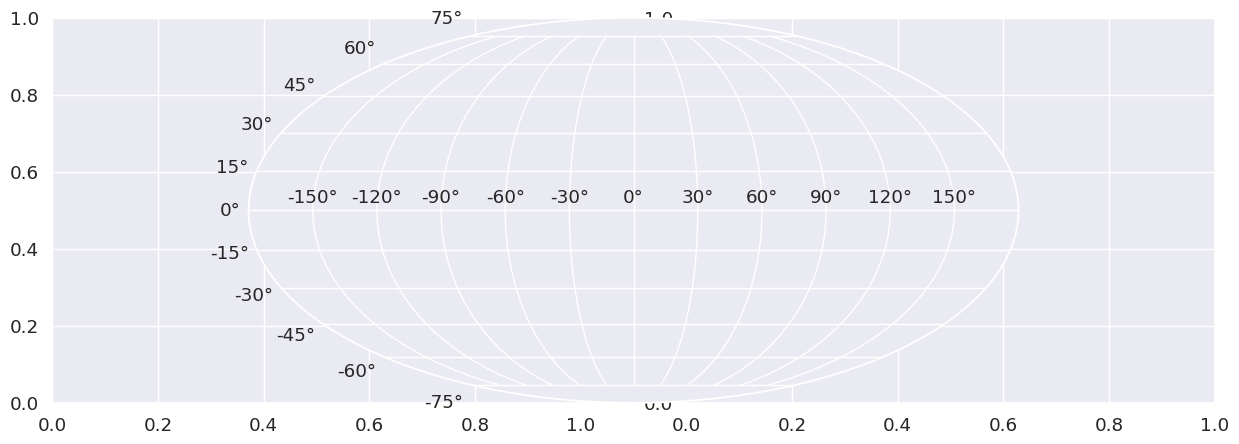

In [22]:
from astropy.coordinates import SkyCoord
import astropy.units as u

with PdfPages('figures/chandra_optical_dw/sky_predicted_datasets.pdf') as pdf:
    # Inside your loop where you plot for each dataframe
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 3 columns for Train, Test, ToTest

    for ax, df, name in zip(axs, dfs, names):
        ax = fig.add_subplot(111, projection='mollweide')

        # Transform coordinates to Galactic
        if name == 'Benchmark':
            skycoord = SkyCoord(ra=df['csc2_ra']*u.degree, dec=df['csc2_dec']*u.degree, frame='icrs')
        else:
            skycoord = SkyCoord(ra=df['chandra_ra']*u.degree, dec=df['chandra_dec']*u.degree, frame='icrs')
        galactic = skycoord.galactic
        l_rad = galactic.l.wrap_at(180*u.degree).radian
        b_rad = galactic.b.radian

        df['l_rad'] = l_rad
        df['b_rad'] = b_rad
        
        # Filter by classification
        l_good = df[df['prediction'] == 1]['l_rad']
        b_good = df[df['prediction'] == 1]['b_rad']
        
        l_bad = df[df['prediction'] == 0]['l_rad']
        b_bad = df[df['prediction'] == 0]['b_rad']
        
        # Initialize figure
        fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': 'mollweide'})

        # KDE plot for good samples
        sns.kdeplot(x=l_good, y=b_good, cmap='BuPu', fill=True, ax=axes[0], common_norm=False, rasterized=True)

        # KDE plot for bad samples
        sns.kdeplot(x=l_bad, y=b_bad, cmap='BuPu', fill=True, ax=axes[1], common_norm=False, rasterized=True)

        # Set titles and save the figure
        axes[0].set_title('Positive')
        axes[1].set_title('Negative')

        # Super title for the page
        plt.suptitle(f"Sky Distribution KDE in Galactic Coordinates ({name})")

        # Save this figure into the PDF
        pdf.savefig(fig, dpi=150);

        # Close the figure to free up memory
        plt.close(fig);

KeyError: 'match_probability'

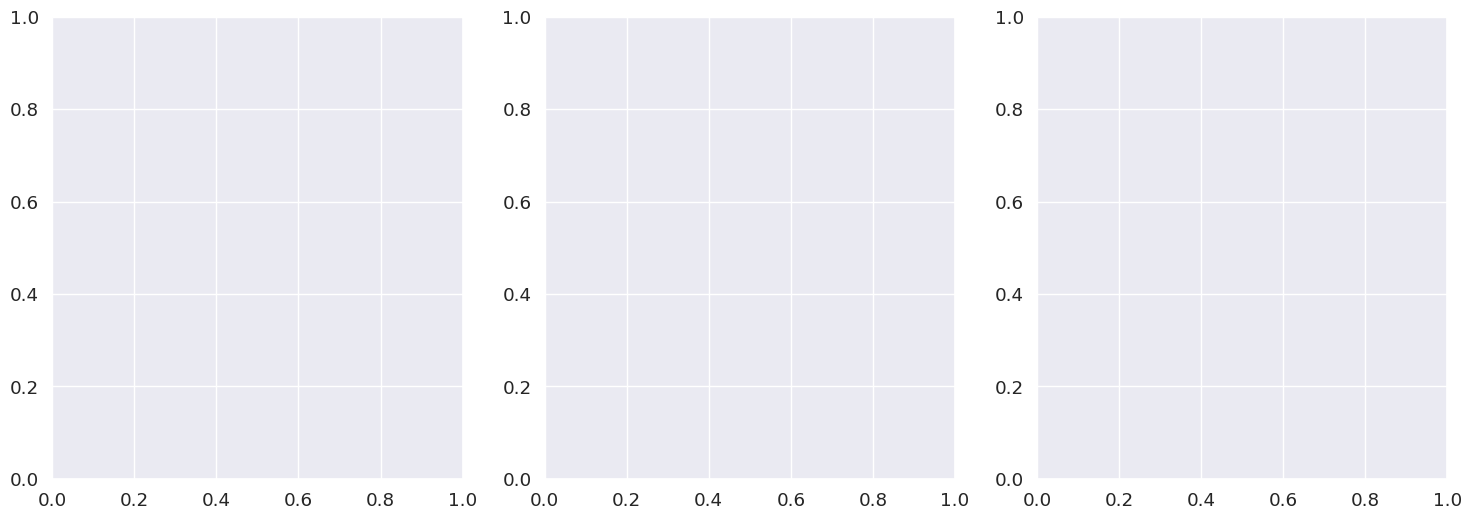

In [177]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('figures/histograms_probs_dongwoo.pdf') as pdf:
    # Plot for each dataset
    for dataset, pred_prob, title in zip([df_train, df_test], 
                                        [y_train_rf_prob, y_pred_rf_prob], 
                                        ['Train', 'Test']):
        
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        
        # Scatter Plot
        cmap = 'coolwarm'
        norm = plt.Normalize(dataset['hard_hs'].min(), dataset['hard_hs'].max())
        sc = ax[0].scatter(pred_prob, dataset['match_probability'], 
                        c=dataset['hard_hs'], cmap=cmap, norm=norm, s=6)
        cbar = plt.colorbar(sc, ax=ax[0])
        cbar.set_label('hard_hs', rotation=270, labelpad=15)
        ax[0].set_title(r'XMatch vs $P_{\mathrm{RF}}$ (%s)' % title)
        ax[0].set_ylabel('XMatch Probability')
        ax[0].set_xlabel(r'$P_{\mathrm{RF}}')
        
        # Histogram: Our Probabilities (Predicted Good)
        sns.histplot(pred_prob[dataset.actual == 1], bins=20, kde=False, ax=ax[1])
        ax[1].set_title(r'$P_{\mathrm{RF}}$ for true positive matches (%s)' % title)
        ax[1].set_xlabel(r'$P_{\mathrm{RF}}')
        ax[1].set_ylabel('Frequency')
        
        # Histogram: Our Probabilities (Predicted Bad)
        sns.histplot(pred_prob[dataset.actual == 0], bins=20, kde=False, ax=ax[2])
        ax[2].set_title(r'$P_{\mathrm{RF}}$ for true negative matches (%s)' % title)
        ax[2].set_xlabel(r'$P_{\mathrm{RF}}')
        ax[2].set_ylabel('Frequency')
        
        plt.tight_layout()
        pdf.savefig(fig); 
plt.close();